### Question 2 Import Libraries

In [7]:
import kornia
import torch
import matplotlib.pyplot as plt
import numpy as np

### Question 2 Code for Seam Carving (shrinking)

In [8]:
def CarvingHelper(img : torch.tensor, seams : list):
    
    ## list to hold each channel
    tensor_list = []

    ## the seam
    s_list = torch.Tensor(seams)
    s_list = s_list.to(torch.int64)

    ## removing the seam
    for channel in range(img.shape[1]):
        mask = torch.ones_like(img[0, channel]).scatter_(1, s_list.unsqueeze(1), 0.)
        result = img[0, channel, mask.bool()].view(img.shape[2], img.shape[3] - 1)
        tensor_list.append(result.unsqueeze(0))

    ## combining the channels
    result_tensor = torch.cat(tensor_list, dim=0)

    return result_tensor.unsqueeze(0)

In [9]:
def MySeamCarving(img, resolution):
    
    _, _, d1, d2 = img.shape

    ## calculating the difference between the original resolution and the desired resolution
    d1_difference = d1 - resolution[0]
    d2_difference = d2 - resolution[1]

    def carve_seams(img, num_seams, transpose=False):
        
        ## transpose if we are trying to remove horizontal seams
        if transpose:
            img = torch.transpose(img, 2, 3)

        for i in range(num_seams):

            r, g, b = torch.chunk(img, 3, dim=1)

            ## calculating energy image E
            E = kornia.filters.spatial_gradient(r, mode='sobel').norm(dim=2)
            E += kornia.filters.spatial_gradient(g, mode='sobel').norm(dim=2)
            E += kornia.filters.spatial_gradient(b, mode='sobel').norm(dim=2)

            ## initializing scoring matrix M
            M = torch.zeros_like(E)
            M[0, 0, :] = E[0, 0, :].clone()

            ## filling the scoring matrix M
            for row in range(1, M.shape[2]):
                for col in range(M.shape[3]):
                    left = max(0, col - 1)
                    right = min(M.shape[3] - 1, col + 1)
                    prev_row = M[0, 0, row - 1, left:right + 1]
                    M[0, 0, row, col] = E[0, 0, row, col] + torch.min(prev_row)

            ## finding the argmin of last row
            seam = [int(torch.argmin(M[0, 0, -1]))]

            ## back tracking
            for row in reversed(range(M.shape[2] - 1)):
                prev_col = seam[-1]
                left = max(0, prev_col - 1)
                right = min(M.shape[3] - 1, prev_col + 1)
                prev_row = M[0, 0, row, left:right + 1]
                prev_col = left + int(torch.argmin(prev_row))
                seam.append(prev_col)

            seam.reverse()

            ## remove seam
            img = CarvingHelper(img, seam)

        if transpose:
            img = torch.transpose(img, 2, 3)

        return img

    if d2_difference > 0:   ## removing vertical seams
        img = carve_seams(img, d2_difference, transpose=False)

    if d1_difference > 0:   ## removing horizontal seams
        img = carve_seams(img, d1_difference, transpose=True)

    return img


### Question 2 Code for Seam Carving (enlarging)

idea: find the optimal seam, duplicate it in the image with the average of left and right values, make the pixels that are just operated on in scoring matrix M to be inf (so that the program won't choose the same seam over and over.)

In [10]:
def CarvingHelper_Enlarge(img : torch.tensor, seams : list):
    
    ## list to hold each channel
    tensor_list = []

    ## the seam
    s_list = torch.Tensor(seams)
    s_list = s_list.to(torch.int64)

    ## adding the seam
    for channel in range(img.shape[1]):
        
        row_list = []

        for i, v in enumerate(s_list):
            left = max(0, v - 1)
            right = min(img.shape[3] - 1, v + 1)
            new_value = (img[0, channel, i, left] + img[0, channel, i, right]) / 2
            new_row = torch.cat((img[0, channel, i, :v], new_value.unsqueeze(0), img[0, channel, i, v:])).unsqueeze(0)
            row_list.append(new_row)

        tensor_list.append(torch.cat(row_list, dim=0).unsqueeze(0))

    result_tensor = torch.cat(tensor_list, dim=0)

    return result_tensor.unsqueeze(0)

In [11]:
def MySeamCarving_Enlarge(img, resolution):
    
    _, _, d1, d2 = img.shape

    ## calculating the difference between the original resolution and the desired resolution
    d1_difference = resolution[0] - d1
    d2_difference = resolution[1] - d2

    def carve_seams(img, num_seams, transpose=False):
        
        ## transpose if we are trying to remove horizontal seams
        if transpose:
            img = torch.transpose(img, 2, 3)

        ## need to hold a list of seams!!! instead of a list of one single seam
        seams = list()

        for i in range(num_seams):

            r, g, b = torch.chunk(img, 3, dim=1)

            ## calculating energy image E
            E = kornia.filters.spatial_gradient(r, mode='sobel').norm(dim=2)
            E += kornia.filters.spatial_gradient(g, mode='sobel').norm(dim=2)
            E += kornia.filters.spatial_gradient(b, mode='sobel').norm(dim=2)

            ## initializing scoring matrix M
            M = torch.zeros_like(E)

            M[0, 0, :] = E[0, 0, :].clone()

            ## filling scoring matrix M
            for row in range(1, M.shape[2]):
                for col in range(M.shape[3]):
                    left = max(0, col - 1)
                    right = min(M.shape[3] - 1, col + 1)
                    prev_row = M[0, 0, row - 1, left:right + 1]
                    M[0, 0, row, col] = E[0, 0, row, col] + torch.min(prev_row)

            ## make seams that have been operated on to be inf so there is no double counting
            for seam in seams:
                for row, col in enumerate(seam):
                    M[0, 0, row, col] = float('inf')
                    M[0, 0, row, col + 1] = float('inf')

            ## finding the argmin of last row
            seam = [int(torch.argmin(M[0, 0, -1]))]

            ## back tracking
            for row in reversed(range(M.shape[2] - 1)):
                prev_col = seam[-1]
                left = max(0, prev_col - 1)
                right = min(M.shape[3] - 1, prev_col + 1)
                prev_row = M[0, 0, row, left:right + 1]
                prev_col = left + int(torch.argmin(prev_row))
                seam.append(prev_col)

            seam.reverse()

            ## add seam
            img = CarvingHelper_Enlarge(img, seam)

            seams.append(seam)

        if transpose:
            img = torch.transpose(img, 2, 3)

        return img

    if d2_difference > 0:   ## adding vertical seams
        img = carve_seams(img, d2_difference, transpose=False)

    if d1_difference > 0:   ## adding horizontal seams
        img = carve_seams(img, d1_difference, transpose=True)

    return img


### Question 2 Part 1 - Image Resizing (shrinking):

my image:

In [12]:
## reading the image of my choosing
img = plt.imread('ae5fffae14814b88b8eb7551ef16ea84.jpg')
img = img.astype(np.float32) / 255.

## converting from numpy to tensor
img_tensor = kornia.image_to_tensor(img.copy())
img_tensor = img_tensor.unsqueeze(0)

## try out seam carving (removing seams)
img_tensor_v = MySeamCarving(img_tensor, (420, 460))

img_tensor_h = MySeamCarving(img_tensor, (320, 560))

(420, 560, 3)


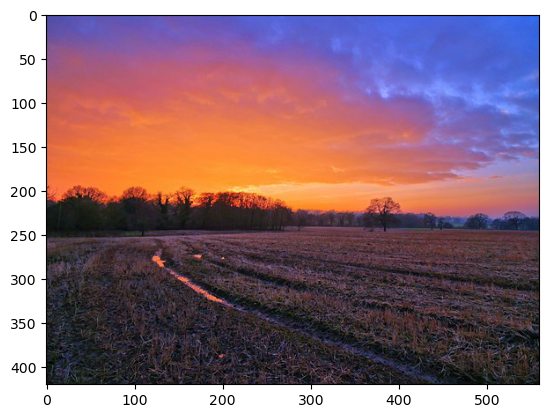

In [13]:
original_img = plt.imread('ae5fffae14814b88b8eb7551ef16ea84.jpg')
original_img = original_img.astype(np.float32) / 255.
print(original_img.shape)
plt.imshow(original_img)

torch.Size([3, 420, 460])


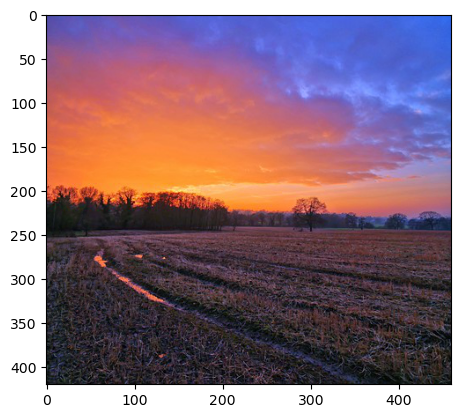

In [14]:
resized_img_v = img_tensor_v.squeeze(0)
print(resized_img_v.shape)
resized_img_v = resized_img_v.permute(1, 2, 0)
resized_img_v = resized_img_v.cpu().numpy()
plt.imshow(resized_img_v)

torch.Size([3, 320, 560])


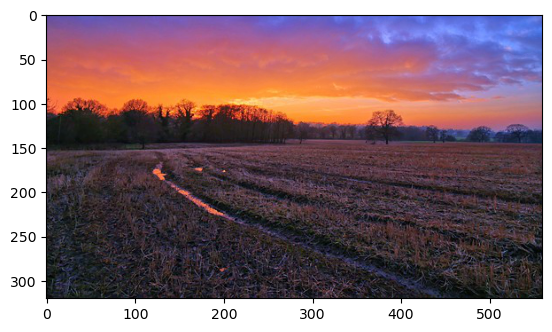

In [15]:
resized_img_h = img_tensor_h.squeeze(0)
print(resized_img_h.shape)
resized_img_h = resized_img_h.permute(1, 2, 0)
resized_img_h = resized_img_h.cpu().numpy()
plt.imshow(resized_img_h)

York image:

In [16]:
## reading the YorkU image
img_york = plt.imread('York.jpg')
img_york = img_york.astype(np.float32) / 255.

## converting from numpy to tensor
york_tensor = kornia.image_to_tensor(img_york.copy())
york_tensor = york_tensor.unsqueeze(0)

## try out seam carving (removing seams)
york_tensor_v = MySeamCarving(york_tensor, (1151, 1200))

york_tensor_h = MySeamCarving(york_tensor, (720, 1728))

(1151, 1728, 3)


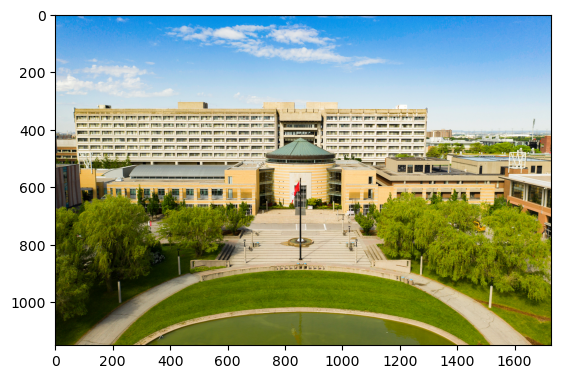

In [17]:
original_img_york = plt.imread('York.jpg')
original_img_york = original_img_york.astype(np.float32) / 255.
print(original_img_york.shape)
plt.imshow(original_img_york)

torch.Size([3, 1151, 1200])


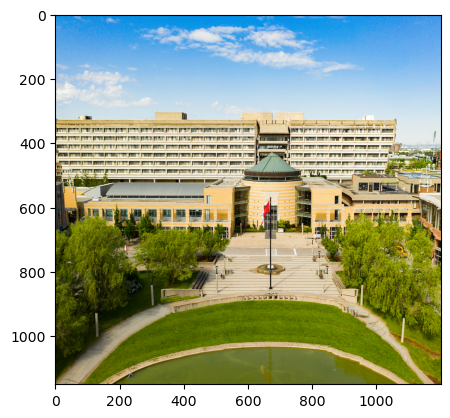

In [18]:
resized_img_v_york = york_tensor_v.squeeze(0)
print(resized_img_v_york.shape)
resized_img_v_york = resized_img_v_york.permute(1, 2, 0)
resized_img_v_york = resized_img_v_york.cpu().numpy()
plt.imshow(resized_img_v_york)

torch.Size([3, 720, 1728])


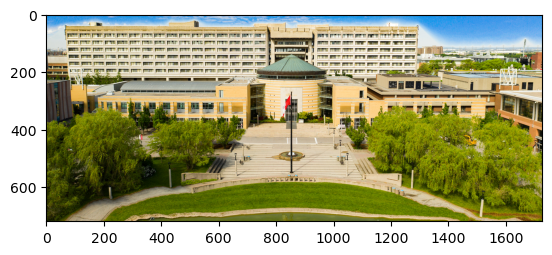

In [19]:
resized_img_h_york = york_tensor_h.squeeze(0)
print(resized_img_h_york.shape)
resized_img_h_york = resized_img_h_york.permute(1, 2, 0)
resized_img_h_york = resized_img_h_york.cpu().numpy()
plt.imshow(resized_img_h_york)

### Question 2 Part 2 - Image Resizing (enlarging):

In [20]:
## reading the image
img = plt.imread('ae5fffae14814b88b8eb7551ef16ea84.jpg')
img = img.astype(np.float32) / 255.

## converting from numpy to tensor
img_tensor = kornia.image_to_tensor(img.copy())
img_tensor = img_tensor.unsqueeze(0)

## try out seam carving (adding seams)
img_tensor_v_a = MySeamCarving_Enlarge(img_tensor, (420, 660))

img_tensor_h_a = MySeamCarving_Enlarge(img_tensor, (520, 560))

(420, 560, 3)


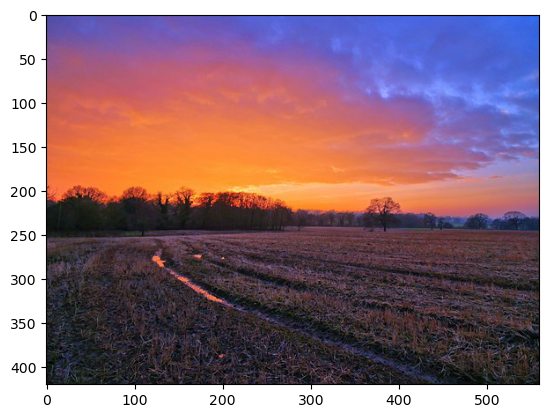

In [21]:
original_img = plt.imread('ae5fffae14814b88b8eb7551ef16ea84.jpg')
original_img = original_img.astype(np.float32) / 255.
print(original_img.shape)
plt.imshow(original_img)

torch.Size([3, 420, 660])


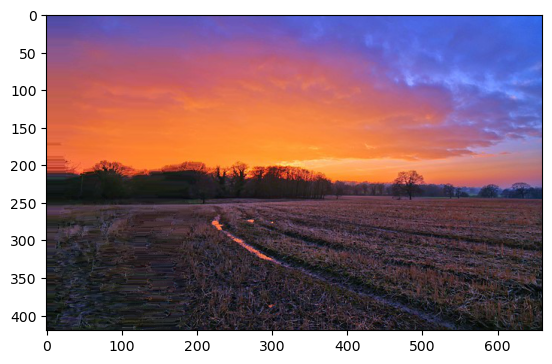

In [22]:
resized_img_v_a = img_tensor_v_a.squeeze(0)
print(resized_img_v_a.shape)
resized_img_v_a = resized_img_v_a.permute(1, 2, 0)
resized_img_v_a = resized_img_v_a.cpu().numpy()
plt.imshow(resized_img_v_a)

torch.Size([3, 520, 560])


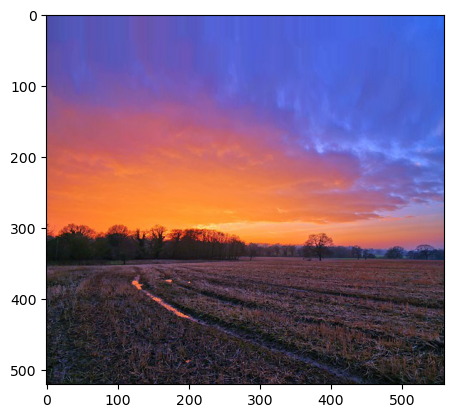

In [23]:
resized_img_h_a = img_tensor_h_a.squeeze(0)
print(resized_img_h_a.shape)
resized_img_h_a = resized_img_h_a.permute(1, 2, 0)
resized_img_h_a = resized_img_h_a.cpu().numpy()
plt.imshow(resized_img_h_a)

### Test

In [1]:
import kornia
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.Size([1, 420, 560])


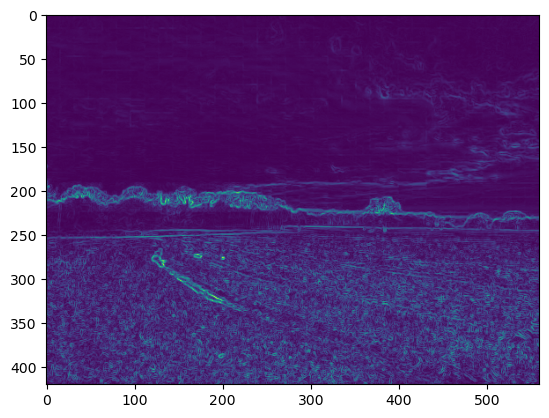

In [3]:
img = plt.imread('ae5fffae14814b88b8eb7551ef16ea84.jpg')
img = img.astype(np.float32) / 255.

img_tensor = kornia.image_to_tensor(img.copy())
img_tensor = img_tensor.unsqueeze(0)

r, g, b = torch.chunk(img_tensor, 3, dim=1)

E1 = kornia.filters.spatial_gradient(r, mode='sobel').norm(dim=2)
E1 += kornia.filters.spatial_gradient(g, mode='sobel').norm(dim=2)
E1 += kornia.filters.spatial_gradient(b, mode='sobel').norm(dim=2)

test1 = E1.squeeze(0)
print(test1.shape)
test1 = test1.permute(1, 2, 0)
test1 = test1.cpu().numpy()
plt.imshow(test1)

torch.Size([1, 420, 560])


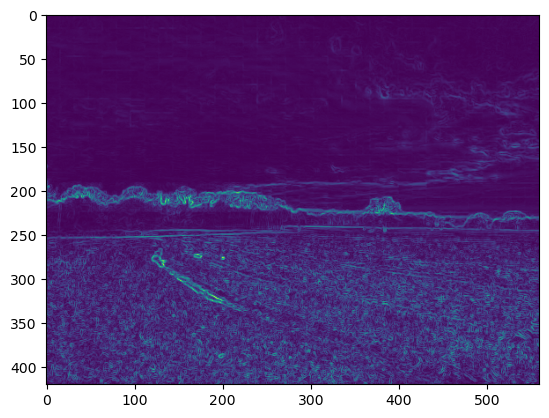

In [4]:
E2 = kornia.filters.SpatialGradient()(r).norm(dim=2)
E2 += kornia.filters.SpatialGradient()(g).norm(dim=2)
E2 += kornia.filters.SpatialGradient()(b).norm(dim=2)

test2 = E2.squeeze(0)
print(test2.shape)
test2 = test2.permute(1, 2, 0)
test2 = test2.cpu().numpy()
plt.imshow(test2)